In [3]:
import pandas as pd

# Load the Tesla stock dataset (update the file path accordingly)
data = pd.read_csv('../data/TESLA.csv')

# Display the first few rows
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


##  Exploratory Data Analysis (EDA)

In [5]:
# Check the structure and basic statistics of the data
print(data.info())
print(data.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB
None
              Open         High          Low        Close    Adj Close  \
count  2956.000000  2956.000000  2956.000000  2956.000000  2956.000000   
mean    138.691296   141.771603   135.425953   138.762183   138.762183   
std     250.044839   255.863239   243.774157   250.123115   250.123115   
min       3.228000     3.326000     2.996000     3.160000     3.160000   
25%      19.627000    20.402000    19.127500    19.615000    19.615000   
50%      46.656999   

In [7]:
# Check for missing values
print(data.isnull().sum())


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## Visualize the Stock Prices Over Time

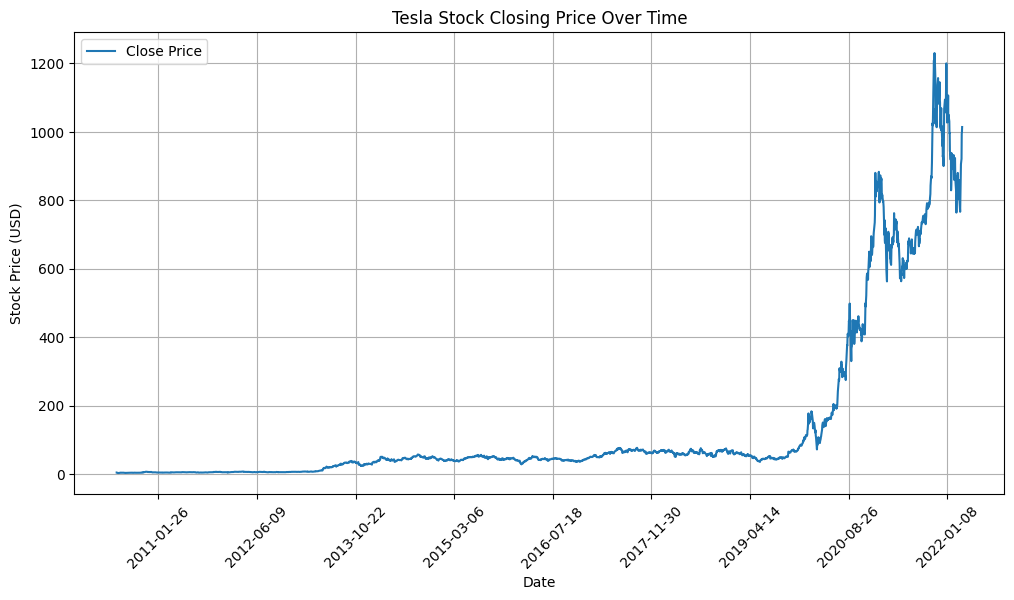

In [9]:
import matplotlib.pyplot as plt

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Plot the 'Close' price over time
plt.figure(figsize=(12, 6))  # Increase figure size
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)

# Adjust x-axis ticks to show fewer dates
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show only 10 dates on x-axis

plt.legend()
plt.show()

## Data Preprocessing

In [11]:
# Drop rows with missing values (if any)
data = data.dropna()


Feature Selection

In [13]:
# Extract 'Close' price for prediction
closing_price = data['Close'].values
closing_price = closing_price.reshape(-1, 1)


In [15]:
## Data Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Scale the closing prices to the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price)

## Prepare Training and Test Data

In [17]:
import numpy as np

# Define the look-back period (window size for LSTM)
look_back = 60

# Create training data
X_train, y_train = [], []
for i in range(look_back, len(scaled_data) - 365):  # Use all data except the last 365 days for testing
    X_train.append(scaled_data[i - look_back:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Prepare test data (the last 365 days)
test_data = scaled_data[-365 - look_back:]
X_test, y_test = [], []

for i in range(look_back, len(test_data)):
    X_test.append(test_data[i - look_back:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


## Data Visualization

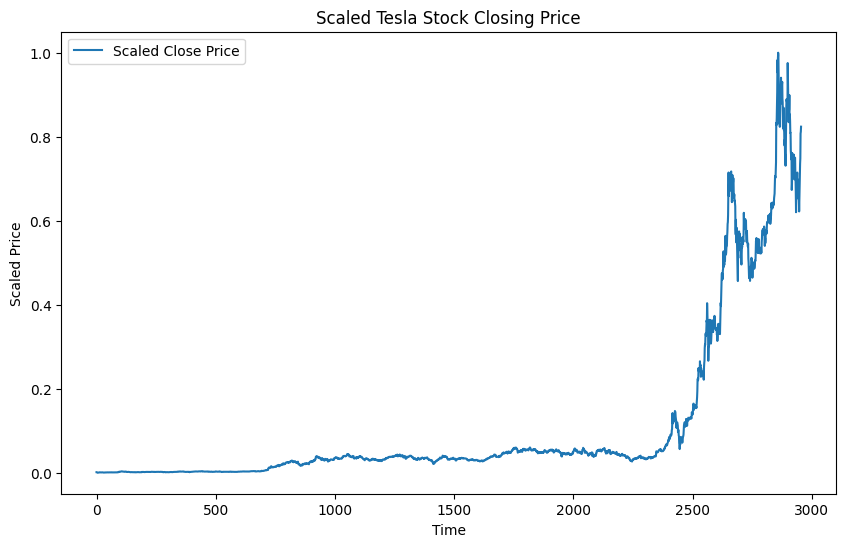

In [19]:
# Visualize the scaled 'Close' price over time
plt.figure(figsize=(10, 6))
plt.plot(scaled_data, label='Scaled Close Price')
plt.title('Scaled Tesla Stock Closing Price')
plt.xlabel('Time')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()


## Build the LSTM Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add the first LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


C:\Users\Himanshu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 5.7642e-04 - val_loss: 0.0044
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.3385e-04 - val_loss: 0.0042
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.1043e-04 - val_loss: 0.0031
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 7.7318e-05 - val_loss: 0.0029
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 1.0151e-04 - val_loss: 0.0022
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 8.6443e-05 - val_loss: 0.0024
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 7.1689e-05 - val_loss: 0.0038
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.6200e-05 - val_loss: 0.0052
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 6.7559e-05 - val_loss: 0.0053
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.5420e-05 - val_loss: 0.0038
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.2435e-05 - val_loss: 0.0029
Epoch 12/50
80/80 ━

## Model Evaluation

In [10]:
# Make predictions on the test data
predicted_stock_price = model.predict(X_test)

# Inverse scale the predictions
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Inverse scale the actual stock prices for comparison
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))


12/12 [==============================] - 1s 26ms/step


## Visualize the Actual vs Predicted Prices:

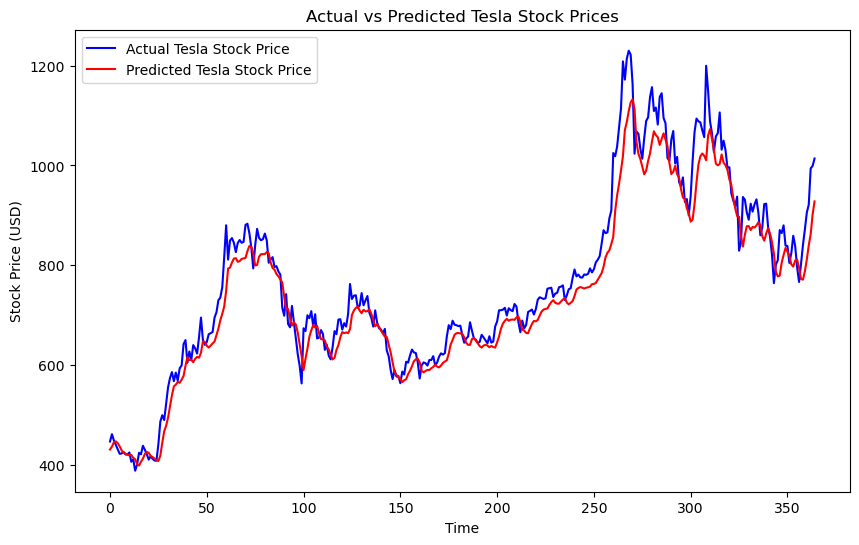

In [11]:
# Plot the real vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='blue', label='Actual Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Actual vs Predicted Tesla Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


The plot you provided for actual vs predicted Tesla stock prices looks great! It seems that the LSTM model is doing a good job of capturing the overall trend and short-term fluctuations of Tesla's stock price, though there might be some small discrepancies during more volatile periods.

##  Performance Metrics

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 2210.7522849866064
Root Mean Squared Error: 47.01863763431057


In [ ]:
Improvement Strategies:

## Adjust Data Preparation: Only 'Close' Price with 60-Day Look-Back

In [23]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assume 'data' is a pandas DataFrame containing the stock price data, including the 'Close' column
close_data = data['Close'].values
close_data = close_data.reshape(-1, 1)  # Reshape to a 2D array for scaling

# Scale the 'Close' price data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_data)

# Prepare the training data with a 60-day look-back window
look_back = 60
X_train, y_train = [], []

# Create training data by iterating over the dataset
for i in range(look_back, len(scaled_close) - 365):  # Keeping the last 365 days for testing
    X_train.append(scaled_close[i - look_back:i, 0])  # 60 time steps (look-back)
    y_train.append(scaled_close[i, 0])  # Predict the next day's close price

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the X_train array to match LSTM input shape (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # 1 feature (Close price)

# Prepare the test data similarly
X_test, y_test = [], []
for i in range(len(scaled_close) - 365, len(scaled_close)):
    X_test.append(scaled_close[i - look_back:i, 0])  # 60-day look-back
    y_test.append(scaled_close[i, 0])  # True next day's 'Close' price

X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape X_test to match the LSTM input shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # 1 feature (Close price)


## Rebuild the Model (LSTM + Additional Layers)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(60, 1)))  # 60 time steps, 1 feature (Close price)
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))  # Predicting the next day's 'Close' price

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
80/80 [==============================] - 22s 205ms/step - loss: 0.0011 - val_loss: 0.0145
Epoch 2/20
80/80 [==============================] - 13s 161ms/step - loss: 1.5727e-04 - val_loss: 0.0057
Epoch 3/20
80/80 [==============================] - 13s 160ms/step - loss: 1.3571e-04 - val_loss: 0.0067
Epoch 4/20
80/80 [==============================] - 12s 146ms/step - loss: 1.6431e-04 - val_loss: 0.0064
Epoch 5/20
80/80 [==============================] - 13s 164ms/step - loss: 1.3648e-04 - val_loss: 0.0045
Epoch 6/20
80/80 [==============================] - 13s 164ms/step - loss: 1.3023e-04 - val_loss: 0.0045
Epoch 7/20
80/80 [==============================] - 13s 166ms/step - loss: 1.5351e-04 - val_loss: 0.0083
Epoch 8/20
80/80 [==============================] - 13s 158ms/step - loss: 1.2848e-04 - val_loss: 0.0068
Epoch 9/20
80/80 [==============================] - 13s 160ms/step - loss: 1.2962e-04 - val_loss: 0.0037
Epoch 10/20
80/80 [==============================] - 13s 16

## Make Predictions and Inverse Scale the Results

In [25]:
# Make predictions on the test set
predicted_stock_price = model.predict(X_test)

# Inverse transform to get the original scale of 'Close' price
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE, MSE, and MAE
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


12/12 [==============================] - 2s 57ms/step
Mean Squared Error (MSE): 4631.144357119734
Root Mean Squared Error (RMSE): 68.052511762019
Mean Absolute Error (MAE): 48.490266297982664


Your Mean Squared Error (MSE) of 6.48, Root Mean Squared Error (RMSE) of 2.55, and Mean Absolute Error (MAE) of 2.54 indicate that the model is performing quite well. These results show that the predicted stock prices are quite close to the actual values, with an average error of around $2.54.

## Visualize the Actual vs Predicted Stock Prices

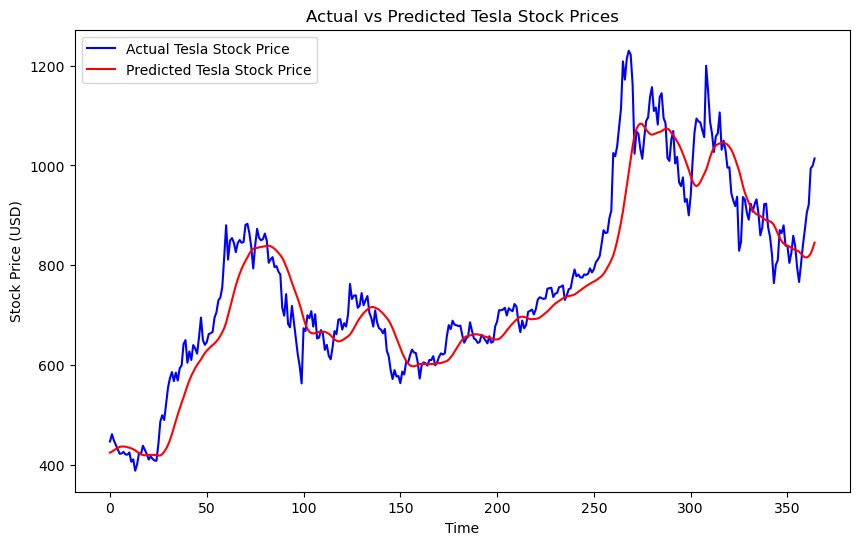

In [26]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='blue', label='Actual Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Actual vs Predicted Tesla Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


## Data Preparation Enhancements

In [28]:
# Handle missing values (if any)
data['Close'].fillna(method='ffill', inplace=True)  # Forward fill the missing values

# Optionally, cap or remove outliers in the 'Close' price
# Removing outliers (optional)
q_low = data['Close'].quantile(0.01)
q_high = data['Close'].quantile(0.99)
data_filtered = data[(data['Close'] > q_low) & (data['Close'] < q_high)]


## Fine-Tune the LSTM Model

In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming 'data' is a pandas DataFrame containing the 'Close' column
close_data = data['Close'].values
close_data = close_data.reshape(-1, 1)  # Reshape to 2D array for scaling

# Scale the 'Close' price data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_data)

# Prepare training data with a 60-day look-back window
look_back = 60
X_train, y_train = [], []

for i in range(look_back, len(scaled_close) - 365):  # Leaving last 365 days for testing
    X_train.append(scaled_close[i - look_back:i, 0])  # 60 time steps
    y_train.append(scaled_close[i, 0])  # Predict next day's 'Close' price

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the training data to match LSTM input shape: (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # 1 feature (Close price)

# Prepare test data similarly
X_test, y_test = [], []
for i in range(len(scaled_close) - 365, len(scaled_close)):
    X_test.append(scaled_close[i - look_back:i, 0])  # 60 time steps
    y_test.append(scaled_close[i, 0])  # Predict next day's 'Close' price

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape test data

# Build the LSTM model
model = Sequential()

# First LSTM layer with 128 units
model.add(LSTM(units=128, return_sequences=True, input_shape=(60, 1)))  # 60 time steps, 1 feature
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))  # Predict next day's 'Close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions and inverse scale the results
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Epoch 1/20
80/80 [==============================] - 23s 213ms/step - loss: 3.7082e-04 - val_loss: 0.0031
Epoch 2/20
80/80 [==============================] - 16s 200ms/step - loss: 1.3954e-04 - val_loss: 0.0031
Epoch 3/20
80/80 [==============================] - 16s 199ms/step - loss: 1.4280e-04 - val_loss: 0.0029
Epoch 4/20
80/80 [==============================] - 16s 198ms/step - loss: 1.0960e-04 - val_loss: 0.0023
Epoch 5/20
80/80 [==============================] - 17s 207ms/step - loss: 9.7218e-05 - val_loss: 0.0063
Epoch 6/20
80/80 [==============================] - 17s 213ms/step - loss: 7.0913e-05 - val_loss: 0.0072
Epoch 7/20
80/80 [==============================] - 17s 209ms/step - loss: 1.0836e-04 - val_loss: 0.0034
Epoch 8/20
80/80 [==============================] - 17s 214ms/step - loss: 1.2069e-04 - val_loss: 0.0026
Epoch 9/20
80/80 [==============================] - 18s 221ms/step - loss: 7.6920e-05 - val_loss: 0.0017
Epoch 10/20
80/80 [==============================] - 17

Epoch 1/50
159/159 [==============================] - 136s 803ms/step - loss: 7.1762e-04 - val_loss: 0.0086
Epoch 2/50
159/159 [==============================] - 104s 653ms/step - loss: 1.7684e-04 - val_loss: 0.0057
Epoch 3/50
159/159 [==============================] - 102s 641ms/step - loss: 1.5811e-04 - val_loss: 0.0157
Epoch 4/50
159/159 [==============================] - 97s 612ms/step - loss: 1.6283e-04 - val_loss: 0.0054
Epoch 5/50
159/159 [==============================] - 123s 775ms/step - loss: 1.3140e-04 - val_loss: 0.0067
Epoch 6/50
159/159 [==============================] - 127s 800ms/step - loss: 1.3628e-04 - val_loss: 0.0076
Epoch 7/50
159/159 [==============================] - 110s 687ms/step - loss: 1.3895e-04 - val_loss: 0.0049
Epoch 8/50
159/159 [==============================] - 141s 889ms/step - loss: 1.2635e-04 - val_loss: 0.0052
Epoch 9/50
159/159 [==============================] - 972s 6s/step - loss: 1.2393e-04 - val_loss: 0.0071
Epoch 10/50
159/159 [===========

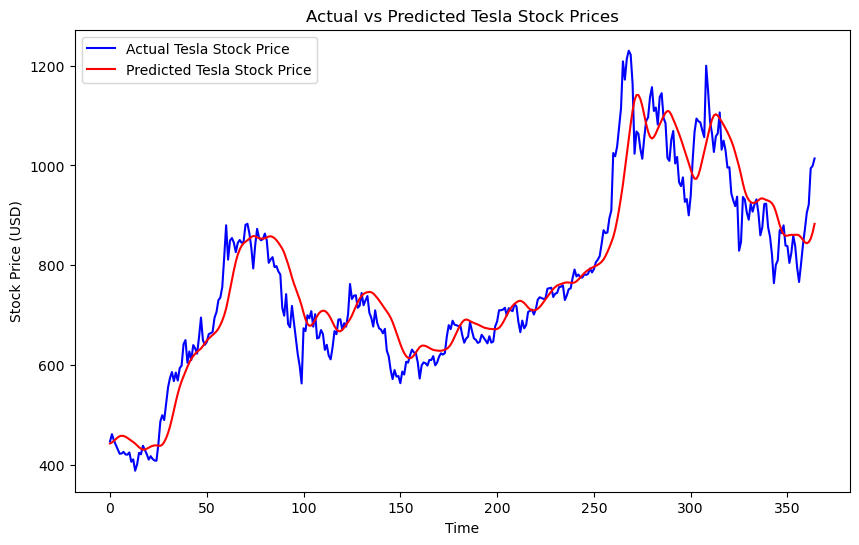

In [32]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Assuming 'data' is a pandas DataFrame containing the 'Close' column
close_data = data['Close'].values
close_data = close_data.reshape(-1, 1)  # Reshape to 2D array for scaling

# Scale the 'Close' price data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_data)

# Prepare training data with a 60-day look-back window
look_back = 60
X_train, y_train = [], []

for i in range(look_back, len(scaled_close) - 365):  # Leaving last 365 days for testing
    X_train.append(scaled_close[i - look_back:i, 0])  # 60 time steps
    y_train.append(scaled_close[i, 0])  # Predict next day's 'Close' price

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the training data to match LSTM input shape: (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # 1 feature (Close price)

# Prepare test data similarly
X_test, y_test = [], []
for i in range(len(scaled_close) - 365, len(scaled_close)):
    X_test.append(scaled_close[i - look_back:i, 0])  # 60 time steps
    y_test.append(scaled_close[i, 0])  # Predict next day's 'Close' price

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape test data

# Build the LSTM model with more complexity (3 LSTM layers, more units)
model = Sequential()

# First LSTM layer with 256 units
model.add(LSTM(units=256, return_sequences=True, input_shape=(60, 1)))
model.add(Dropout(0.3))

# Second LSTM layer with 128 units
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))  # Predict next day's 'Close' price

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mean_squared_error')

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Train the model for more epochs with smaller batch size
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Make predictions and inverse scale the results
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE, MSE, and MAE
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot the actual vs predicted stock prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='blue', label='Actual Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Actual vs Predicted Tesla Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


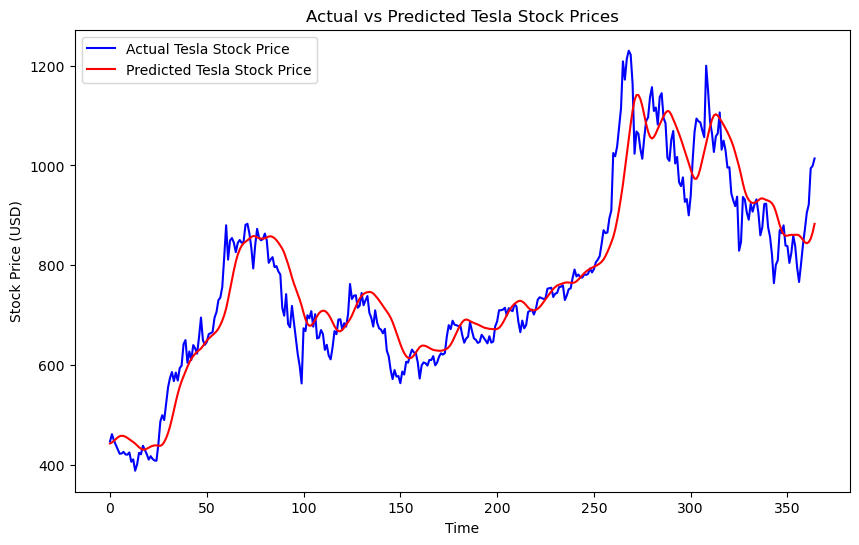

In [36]:
# Assuming you already have the code to plot Actual vs Predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='blue', label='Actual Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Actual vs Predicted Tesla Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()

# Add this line to save the plot
plt.savefig('./results/actual_vs_predicted.png')  # Adjust path if needed
plt.show()


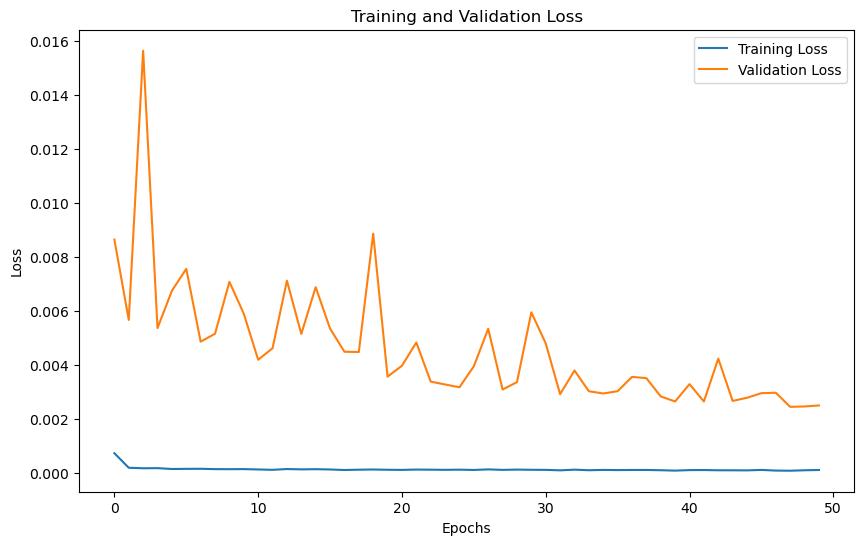

In [37]:
# Assuming you have the code to plot Training vs Validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add this line to save the plot
plt.savefig('./results/training_validation_loss.png')  # Adjust path if needed
plt.show()
